<a href="https://colab.research.google.com/github/kkrusere/Time-Series-Analysis-on-Freighter-shipping-prices/blob/main/Time_series_Container_shipping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Time Series Analysis and Forecasting On Container Shipping Prices**<center>
<center> <em>A time series is a series of data points indexed in time order. <strong>Time Series Analysis</strong> comprises <strong>methods</strong> for analyzing time series data to extract meaningful <strong>statistics and other characteristics</strong> of the data. <strong>Time Series Forecasting</strong> is the use of the model to <strong>predict</strong> future values based on previously observed values. Here we are going to be doing a time series analysis on container shipping prices for three routes, North America East Coast to China/East Asia, Europe to North America East Coast, and Europe to South America West Coast using Data Collected from The Baltic Exchange, a membership organization for the maritime industry, and freight market information provider for the trading and settlement of physical and derivative contracts.</em></center>
<center><img src='https://github.com/kkrusere/Time-Series-Analysis-on-Freighter-shipping-prices/blob/main/assets/contaner_shipping.jpeg?raw=1' width=600/></center>


<br>
<br>
The ARIMA (**AutoRegressive Integrated Moving Average**) model is a popular and widely used statistical **method** for time series analysis and forecasting.

We are going to be using the ARIMA model to analize the container shipping price data for the below routes:
1. **FBX04:** North America East Coast to China/East Asia
2. **FBX22:** Europe to North America East Coast
3. **FBX26:** Europe to South America West Coast

## **Data Colection, Cleanning and Preperation**


### **1. Data Colection**

Data was collected from [The Baltic Exchange](https://www.balticexchange.com/en/who-we-are.html), which is the world's leading source of independent maritime market data. We managed to scrape json files for the three routes usining the Google Chrome developer tools as 'har' files and then used the [HAR File Web Scraper](https://stevesie.com/har-file-web-scraper) which outputed the json files.
<br>
<br>
The below Image is a sameple of what the json file looks.


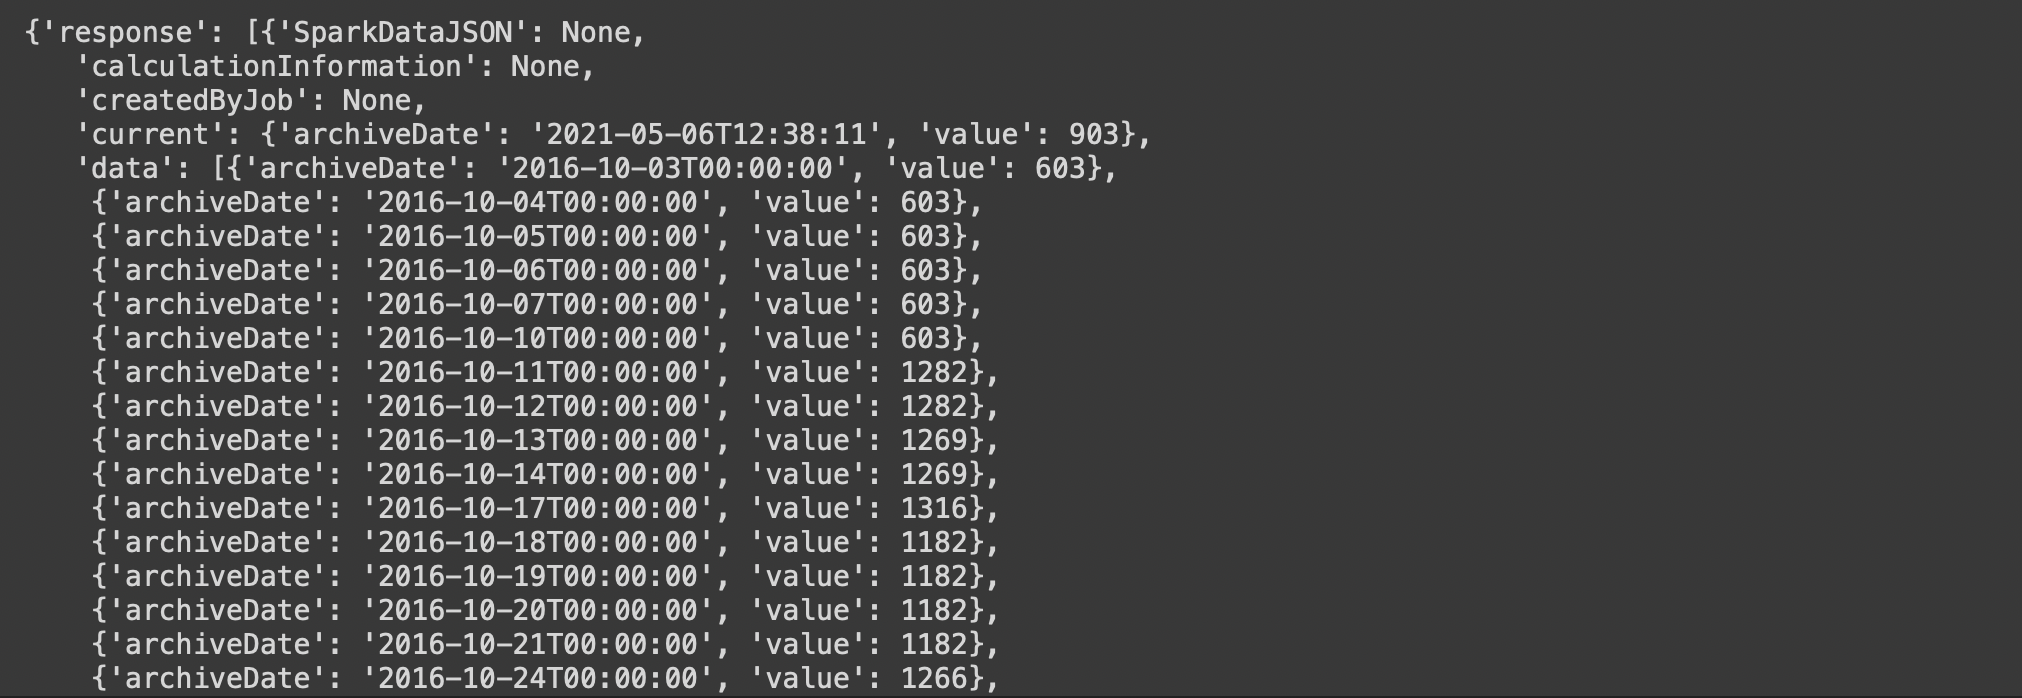

In [ ]:
%cd /content/drive/MyDrive/Data_Mining_Project

/content/drive/MyDrive/Data_Mining_Project


In [ ]:
import warnings
import itertools
import json #we are going to read the json files using the  json file module
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime

 

%matplotlib inline

rcParams['figure.figsize'] = 15, 7

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#we  will create a function that we will use to convert the json files to data frame 
def convert_json_to_dataframe(file_path):
  f = open(file_path,'r')
  data = json.load(f)
  data = data['response']
  data = data[0]
  data = data['data']
  temp_dict = {}
  for entry in data:
    temp_dict[entry['archiveDate']] = entry['value']

  df = pd.DataFrame(list(temp_dict.items()),columns = ['Dates','Price']) 

  return df

In [ ]:
#we are now going to load the three json files into pandas dataframes 

#FBX04: North America East Coast to China/East Asia
df_FBX04 = convert_json_to_dataframe('/content/drive/MyDrive/Data_Mining_Project/FBX04.json')
#FBX22: Europe to North America East Coast
df_FBX22 = convert_json_to_dataframe('/content/drive/MyDrive/Data_Mining_Project/FBX22.json')
#FBX26: Europe to South America West Coast
df_FBX26 = convert_json_to_dataframe('/content/drive/MyDrive/Data_Mining_Project/FBX26.json')

In [ ]:
#we will do a quick look at the data using the 'info' function built in to pandas
df_FBX04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Dates   1195 non-null   object
 1   Price   1195 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.8+ KB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_FBX22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Dates   1195 non-null   object
 1   Price   1195 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.8+ KB


In [ ]:
df_FBX26.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Dates   1195 non-null   object
 1   Price   1195 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.8+ KB


The first thing that we need to take note of is that since the data is from  2016-10-03 to 2021-05-06, the number of entries should be 1667 instead of 1195. The implies that the data is missing the weekends, we are going to be needing for a time series data analysis and forecasting.



## **Data Cleanning and Preperation**
First we are going to make the **Date** column as the index of the data frame as that is a requirement for a time searies data set.
<br>
<br>
After we will use the Pandas 'dataframe.asfreq()' function is used to convert TimeSeries to specified frequency which will be the series to date/day frequency. The "freq ='D'" will expose the missing weekends and they will have NaN value for the price.
<br>
<br>
Then will use the the Pandas 'dataframe.ffill()' function is used to fill the missing value in the dataframe. ‘ffill’ stands for ‘forward fill’ and will propagate last valid observation forward.


In [ ]:
#This function is going to be for making the dates column the index of the dataframes 
def date_index_df(df):
  df['Dates'] = pd.to_datetime(df['Dates']).dt.date
  df.set_index('Dates',inplace=True)
  df.sort_index(inplace= True)

  return df

In [ ]:
df_FBX04 = date_index_df(df_FBX04)
df_FBX22 = date_index_df(df_FBX22)
df_FBX26 = date_index_df(df_FBX26)

In [ ]:
#for example lets take a look at df_FBX04
df_FBX04.head()

Price
Dates            
2016-10-03    603
2016-10-04    603
2016-10-05    603
2016-10-06    603
2016-10-07    603

In [ ]:
#now we are going to us the ".asfreq"
df_FBX04 = df_FBX04.asfreq(freq='D')
df_FBX22 = df_FBX22.asfreq(freq='D')
df_FBX26 = df_FBX26.asfreq(freq='D')

In [ ]:
#fora quick check the info of df_FBX04 and will see that the number of entries is now 1677
df_FBX04.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1677 entries, 2016-10-03 to 2021-05-06
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1195 non-null   float64
dtypes: float64(1)
memory usage: 26.2 KB


In [ ]:
#for example lets take a look at df_FBX04
df_FBX04.head(10)

Price
Dates             
2016-10-03   603.0
2016-10-04   603.0
2016-10-05   603.0
2016-10-06   603.0
2016-10-07   603.0
2016-10-08     NaN
2016-10-09     NaN
2016-10-10   603.0
2016-10-11  1282.0
2016-10-12  1282.0

In [ ]:
df_FBX04.tail(10)

Price
Dates             
2021-04-27   957.0
2021-04-28  1004.0
2021-04-29   926.0
2021-04-30   926.0
2021-05-01     NaN
2021-05-02     NaN
2021-05-03   903.0
2021-05-04   903.0
2021-05-05   903.0
2021-05-06   903.0

From the above you can see that we have the "NaN" values for the weekends, which we are going to fill using the forward fill pandas function


In [ ]:
#we can check the NaN values, which will come out to be 482 entries 
df_FBX04.isna().sum()

Price    482
dtype: int64

In [ ]:
#now we will use the forward fill function 
df_FBX04 = df_FBX04.ffill()
df_FBX22 = df_FBX22.ffill()
df_FBX26 = df_FBX26.ffill()

In [ ]:
#we can check the NaN values, which will come out to be 0 entries 
df_FBX04.isna().sum()

Price    0
dtype: int64

In [ ]:
df_FBX04.tail(10)

Price
Dates             
2021-04-27   957.0
2021-04-28  1004.0
2021-04-29   926.0
2021-04-30   926.0
2021-05-01   926.0
2021-05-02   926.0
2021-05-03   903.0
2021-05-04   903.0
2021-05-05   903.0
2021-05-06   903.0

## **EDA**

For EDA we are going to be plotting the data from the three datasets and just have a visual representation of the data.

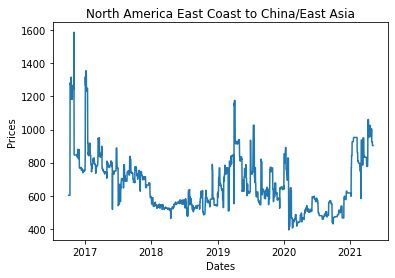

In [ ]:
plt.title('North America East Coast to China/East Asia')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_FBX04)

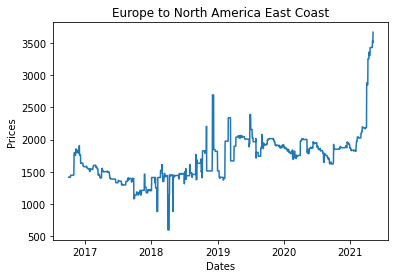

In [ ]:
plt.title('Europe to North America East Coast')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_FBX22)

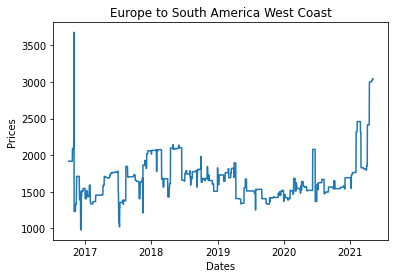

In [ ]:
plt.title('Europe to South America West Coast')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_FBX26)

*Distribution* of the Prices over the series

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


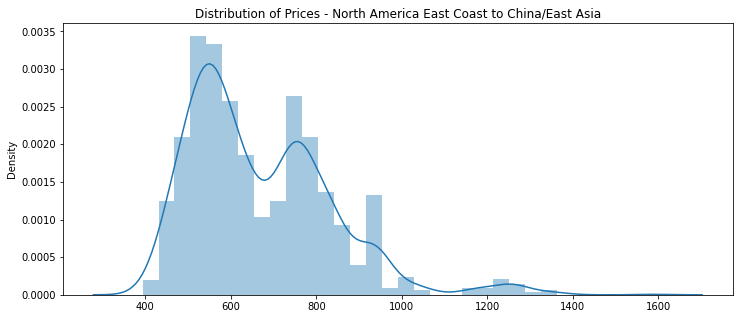

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Prices - North America East Coast to China/East Asia")
ax = sns.distplot(df_FBX04)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


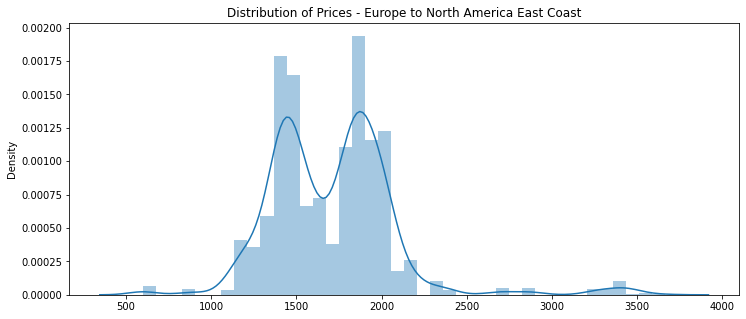

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Prices - Europe to North America East Coast")
ax = sns.distplot(df_FBX22)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


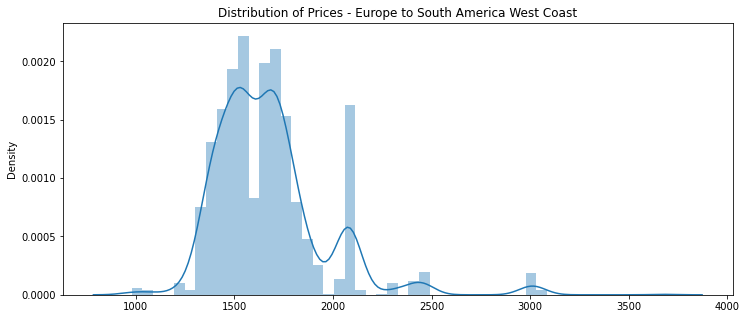

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Prices - Europe to South America West Coast")
ax = sns.distplot(df_FBX26)

### **Data decomposition**
Next we will have a visual representation of the data decomposed into, Trend, Seasonality, and Residuals (aslso called irregularities)<br>

**Trend:** Upward & downward movement of the data with time over a large period of time
<br>
**Seasonality:** Seasonal variance 
<br>
**Residuals/Irregularity:** Spikes & troughs at random intervals

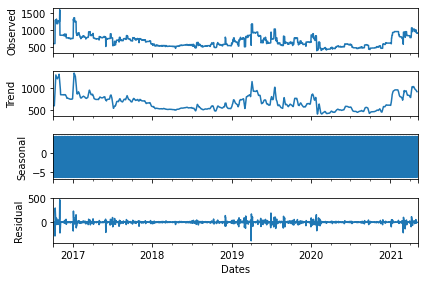

In [ ]:
FBX04_decomposition = sm.tsa.seasonal_decompose(df_FBX04, model='additive')
figure = FBX04_decomposition.plot()
plt.show()

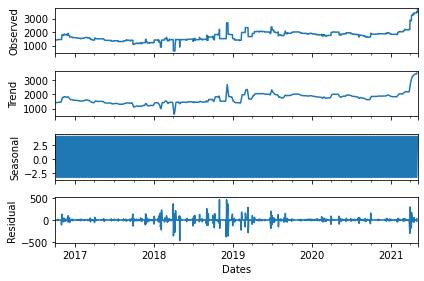

In [ ]:
FBX22_decomposition = sm.tsa.seasonal_decompose(df_FBX22, model='additive')
figure = FBX22_decomposition.plot()
plt.show()

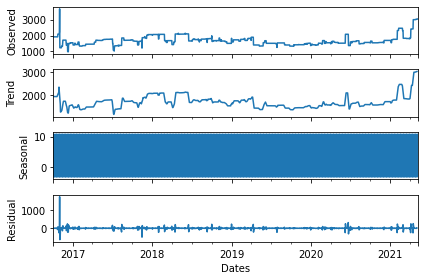

In [ ]:
FBX26_decomposition = sm.tsa.seasonal_decompose(df_FBX26, model='additive')
figure = FBX26_decomposition.plot()
plt.show()

From the above we can see that Trend and Residuals are mostly responsible for the shape of our observed plot (inturn out data sets). <br>
The seasonallity is not well defined hence, it has minimal to zero contribution to the output shape of our observed plot shape and datasets.
<br>
This will play a significant part of our model hyperparameterization tuning 

### **Stationarirty** 
Stationarity means that the statistical properties of a process generating a time series do not change over time.<br>

Since time series models should be applied to stationery data, before we can build a model, we will check to make sure/ensure that the time series is stationary / data is stationery using the Rolling Statistics, where we plot the rolling mean and rolling standard deviation, and Augmented Dickey-Fuller Test at which we will be checking the p-value for which a time series is considered stationary if the p-value is low and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

### **Note that this is Part is only for the EDA as the stationarirty of the time series data set will the take care of in the hyperparameter tuning** 

**bold text**### **Rolling Statistics**

A simple rolling average is the unweighted mean of the last n values. 

In [ ]:
#the below function is for calculating and ploting the rolling stas
def plot_rolling_stats(df):
  rolling_mean = df.rolling(window = 12).mean()
  rolling_std = df.rolling(window = 12).std()
  plt.plot(df, color = 'blue', label = 'Original')
  plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
  plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
  plt.legend(loc = 'best')
  plt.title('Rolling Mean & Rolling Standard Deviation')
  plt.show()

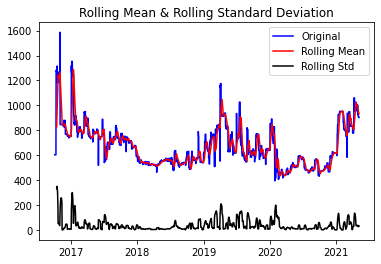

In [ ]:
plot_rolling_stats(df_FBX04)

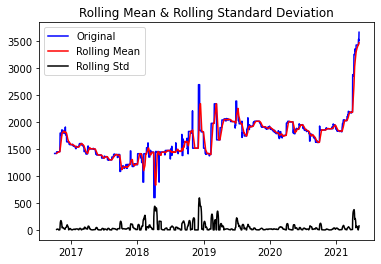

In [ ]:
plot_rolling_stats(df_FBX22)

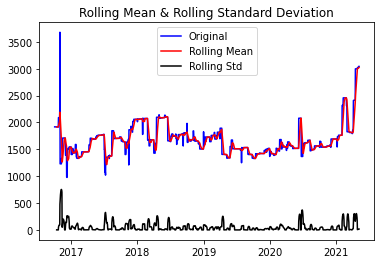

In [ ]:
plot_rolling_stats(df_FBX26)

### **Augmented Dickey-Fuller Test**

The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset)


In [ ]:
#the below function calculates the adfuller test
def adfuller_test(df):
  result = adfuller(df['Price'])
  print('ADF Statistic: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t{}: {}'.format(key, value))

In [ ]:
print("FBX04: North America East Coast to China/East Asia")
adfuller_test(df_FBX04)

FBX04: North America East Coast to China/East Asia
ADF Statistic: -3.8598512204165556
p-value: 0.0023510135677722636
Critical Values:
	1%: -3.4343097809950986
	5%: -2.8632890172254655
	10%: -2.5677011356149544


In [ ]:
print("FBX22: Europe to North America East Coast")
adfuller_test(df_FBX22)

FBX22: Europe to North America East Coast
ADF Statistic: -0.7669367954843076
p-value: 0.8286417692126273
Critical Values:
	1%: -3.4342764940643535
	5%: -2.863274324197044
	10%: -2.5676933117822287


In [ ]:
print("FBX26: Europe to South America West Coast")
adfuller_test(df_FBX26)

FBX26: Europe to South America West Coast
ADF Statistic: -3.582070801114545
p-value: 0.006113192950505476
Critical Values:
	1%: -3.434262398939653
	5%: -2.8632681024848226
	10%: -2.567689998815249


The adfuller test shows that our data is close to stationary but not stationary especially if you put together the rolling stats and the adfuller test.<br>
<br>
Another way that can be used to check the stationarity of the time series dataset is the Autocorrelation.
> Autocorrelation, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay. 

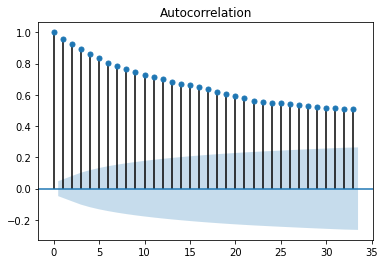

In [ ]:
plot_acf(df_FBX04);


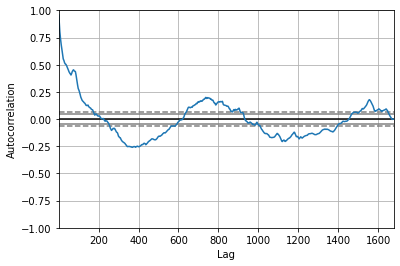

In [ ]:
autocorrelation_plot(df_FBX04)

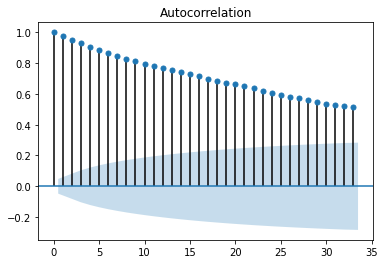

In [ ]:
plot_acf(df_FBX22);


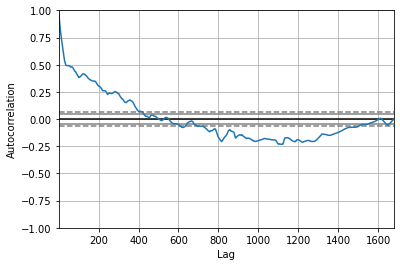

In [ ]:

autocorrelation_plot(df_FBX22)

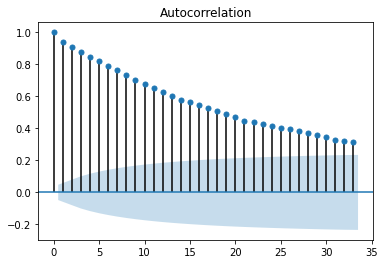

In [ ]:
plot_acf(df_FBX26);


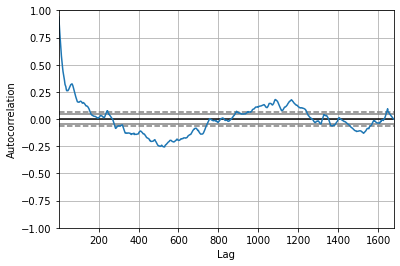

In [ ]:
autocorrelation_plot(df_FBX26)



```
# This is formatted as code
```

The autocorelation plots pretty much show that our dataset are not stationary.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters that account for seasonality, trend, and noise in data

* p: number of autoregressive terms (AR order)
> AutoRegression. A model that uses the dependent relationship between an observation and some number of lagged observations.(also called the lag order)
* d: number of nonseasonal differences (I/differencing order)
> Integrated. The use of differencing of raw observation for example subtracting an observation from an observation at the previous time step to make the time series stationary.(also called the degree of differencing)
* q: number of moving-average terms (MA order)
>  Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.(also called the order of moving average)

In [ ]:
#the below fuction is going to create a ARIMA model for our time series dataset 
def ARIMA_model(df):
  X = df.values
  X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)
  history = [x for x in X_train]
  predictions = list()
  # walk-forward validation
  for t in range(len(X_test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
  # evaluate forecasts
  rmse = sqrt(mean_squared_error(X_test, predictions))
  print('Test RMSE: %.3f' % rmse)
  # plot forecasts against actual outcomes
  plt.plot(X_test)
  plt.plot(predictions, color='red')
  plt.show()
  return model_fit

In [ ]:
# function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    print('HERE I AM 1')
    # split=int(len(data) * 0.8) 
    # #  train and test variables
    # data = data.values
    # train, test = data[0:split], data[split:len(data)]
    X = data.values
    X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)
    past=[x for x in X_train]
    # predictions
    predictions = list()
    for i in range(len(X_test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        print(i)
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        print('HERE I AM 2')
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(X_test[i])
    # calculate out of sample error
    error = mean_squared_error(X_test, predictions)
    print('HERE I AM 3')
    # Return the error
    return error

In [ ]:
# function to evaluate different ARIMA models with several different p, d, and q values
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)

                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    print(f"i am here mse is: {mse}")
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.12f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.12f' % (best_cfg, best_score))

In [ ]:
#  selecting values for each parameter: p_values, d_values and q_values

p_values = [x for x in range(0, 6)]
d_values = [x for x in range(0, 6)]
q_values = [x for x in range(0, 6)]

In [ ]:
evaluate_models(df_FBX04, p_values, d_values, q_values)

HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631
HERE I AM 2
632
HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 29922.023345799087
ARIMA(0, 0, 0) MSE=29922.023345799087
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455
HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455
HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461
HERE I AM 2
462
HERE I AM 2
463
HERE I AM 2
464
HERE I AM 2
465
HERE I AM 2
466
HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610
HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622
HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628
HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631
HERE I AM 2
632
HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Streaming output truncated to the last 5000 lines.
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:225: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encount

Streaming output truncated to the last 5000 lines.
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
594
HERE I AM 2
595


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
611
HERE I AM 2
612


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
613
HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622
HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628
HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
632
HERE I AM 2
633


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1538.9162958039435
ARIMA(1, 2, 1) MSE=1538.916295803944
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
210
HERE I AM 2
211
HERE I AM 1
0


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
27
HERE I AM 2
28


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
30


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
31


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
33


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
34


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
61


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
62


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
101
HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
103


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
104


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
110


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
111
HERE I AM 2
112


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
116
HERE I AM 2
117


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
118
HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
123


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
124


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
125


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
126


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
127


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
128


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
131


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
138


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
145


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
163


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
166


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
167


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
171


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
172


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
173


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
174


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
181


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
188


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
192


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
193


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
198


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
199


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
211


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
212


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215
HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
221


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
225
HERE I AM 2
226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
227


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
235


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
236
HERE I AM 2
237


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
238
HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240
HERE I AM 2
241


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
245


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
33


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
34


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
61


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
62


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
97


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
103
HERE I AM 2
104


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
108
HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
110
HERE I AM 2
111


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
112


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
113


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
114
HERE I AM 2
115


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
116


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
117


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
118


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
123


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
124


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
125


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
126


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
127


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
128


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
131


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
138


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
145


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
163


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
166


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
167


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
171


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
172


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
173


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
174


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
181


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
188


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
192


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
193


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
198


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
199


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
211


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
212


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
221
HERE I AM 2
222


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237
HERE I AM 2
238


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
239
HERE I AM 2
240


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
268
HERE I AM 2
269


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1541.0104594658844
ARIMA(1, 2, 4) MSE=1541.010459465884
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
226
HERE I AM 2
227


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
228
HERE I AM 2
229


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
230


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628
HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631
HERE I AM 2
632
HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1540.9987096605228
ARIMA(1, 2, 5) MSE=1540.998709660523
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid val

HERE I AM 2
25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
66
HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


HERE I AM 2
93
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
22


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
466
HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
558


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588
HERE I AM 2
589
HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610
HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1541.067854022914
ARIMA(2, 2, 1) MSE=1541.067854022914
HERE I AM 1
0
HERE I AM 2
1


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42
HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
52
HERE I AM 2
53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
101


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
103


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
104


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
108


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
114
HERE I AM 2
115


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
116


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
117


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
118
HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
125


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
126


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
127


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
128


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
131


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
138


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
145


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
163


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
166


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
167


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
171


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
172


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
173


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
174


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
181


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
188


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
192


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
193


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
198


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
199


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206
HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
211


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
212


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
216
HERE I AM 2
217


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
218
HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
230
HERE I AM 2
231


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
232


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
253
HERE I AM 2
254


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
259
HERE I AM 2
260


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
303


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455
HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461
HERE I AM 2
462
HERE I AM 2
463


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
464
HERE I AM 2
465
HERE I AM 2
466
HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588
HERE I AM 2
589
HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610
HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1538.925127449022
ARIMA(2, 2, 2) MSE=1538.925127449022
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
61


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
62


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
3
HERE I AM 2
4


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
6


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
10


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
14
HERE I AM 2
15


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
16
HERE I AM 2
17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
18


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
19
HERE I AM 2
20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
21
HERE I AM 2
22


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
23


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
24
HERE I AM 2
25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
30


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
31
HERE I AM 2
32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41
HERE I AM 2
42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50
HERE I AM 2
51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
63
HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66
HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
75
HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80
HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
82
HERE I AM 2
83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
103
HERE I AM 2
104


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
108
HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
110
HERE I AM 2
111


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
112
HERE I AM 2
113


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
114


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122
HERE I AM 2
123


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
124
HERE I AM 2
125


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
126


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
141
HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152
HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159
HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162
HERE I AM 2
163


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177
HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
185
HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
192
HERE I AM 2
193


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
194
HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215
HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
217


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
218


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
225


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229
HERE I AM 2
230


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
231


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
232


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
233


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
234
HERE I AM 2
235


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
238


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
239
HERE I AM 2
240


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
241


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
256
HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258
HERE I AM 2
259


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
260


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
261


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
262


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
266


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
267


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
268


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
269


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
270


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
277
HERE I AM 2
278


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
279
HERE I AM 2
280


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
281


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
282
HERE I AM 2
283


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
284
HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
286
HERE I AM 2
287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
288


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
302
HERE I AM 2
303


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
306


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
307


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
308


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
309


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
310
HERE I AM 2
311


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
312
HERE I AM 2
313


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
321


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
322


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
323
HERE I AM 2
324


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
325


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
326


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
327
HERE I AM 2
328


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
329
HERE I AM 2
330


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
331
HERE I AM 2
332


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
333


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
334


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
341


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
342


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
343
HERE I AM 2
344


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
345


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
346
HERE I AM 2
347


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
348
HERE I AM 2
349


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
362


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
369


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
373
HERE I AM 2
374


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
375


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
376


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
377
HERE I AM 2
378


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
379


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
380


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
381


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
382
HERE I AM 2
383


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
393


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
409
HERE I AM 2
410


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
411
HERE I AM 2
412


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
418


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
419
HERE I AM 2
420


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
421


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
425


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
435


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
436


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
437
HERE I AM 2
438


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
439


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
440
HERE I AM 2
441


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
442
HERE I AM 2
443


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
444
HERE I AM 2
445


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
451
HERE I AM 2
452


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
456


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
457


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
458
HERE I AM 2
459


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
460
HERE I AM 2
461


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
462
HERE I AM 2
463


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
464


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
465
HERE I AM 2
466


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
467


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
468


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
469


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
473


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
474


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
480


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
481


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
482


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
486
HERE I AM 2
487


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
492


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
493


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
494


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
495
HERE I AM 2
496


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
503
HERE I AM 2
504


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
505


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
506
HERE I AM 2
507


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
508
HERE I AM 2
509


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
510
HERE I AM 2
511


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
517
HERE I AM 2
518


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
519


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
520


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
531
HERE I AM 2
532


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
533


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
538


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
539
HERE I AM 2
540


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
541


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
542


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
554


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
555


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
556


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
563
HERE I AM 2
564


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
569


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
570


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
571


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
572
HERE I AM 2
573


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
574


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
575


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
580


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
589


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
593


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
599
HERE I AM 2
600


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
601
HERE I AM 2
602


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
603


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
607
HERE I AM 2
608


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
609


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
610


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
611


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
612


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
613


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
621
HERE I AM 2
622


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
623


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
624
HERE I AM 2
625


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
629
HERE I AM 2
630


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
631


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
632
HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
636


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
637
HERE I AM 2
638


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
639


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
640
HERE I AM 2
641


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
642


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
643


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
644


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
645


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
646
HERE I AM 2
647


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
654
HERE I AM 2
655


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
660
HERE I AM 2
661


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
667


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1527.3619197077185
ARIMA(2, 2, 4) MSE=1527.361919707718
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
4


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
18
HERE I AM 2
19


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
21
HERE I AM 2
22


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
23
HERE I AM 2
24


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
26


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
27


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
28
HERE I AM 2
29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
30


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
31


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
33


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
34


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47
HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49
HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51
HERE I AM 2
52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
53
HERE I AM 2
54


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
58


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
75
HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
86
HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95
HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
123
HERE I AM 2
124


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
131
HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133
HERE I AM 2
134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
138
HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140
HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142
HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
145
HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153
HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159
HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
166


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177
HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
191
HERE I AM 2
192


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201
HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203
HERE I AM 2
204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
217


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
227


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
238
HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240
HERE I AM 2
241


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
251


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
256


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
261
HERE I AM 2
262


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
263


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
274
HERE I AM 2
275


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
276


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
277


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
278
HERE I AM 2
279


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
286
HERE I AM 2
287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
291


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
292


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
293


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
294


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
295


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
296


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
303
HERE I AM 2
304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
308
HERE I AM 2
309


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
310
HERE I AM 2
311


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
312


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
313


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
314


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
315


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
328


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
329
HERE I AM 2
330


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
338


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
339


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
350


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
351


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
357


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
358


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
359


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
360


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
361


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
362
HERE I AM 2
363


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
368
HERE I AM 2
369


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
376


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
377


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
378


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
382


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
383


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
389


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
390


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
391


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
392
HERE I AM 2
393


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
404


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
405


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
410


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
411
HERE I AM 2
412


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
413


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
414


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
415
HERE I AM 2
416


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
417


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
418
HERE I AM 2
419


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
437


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
438


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
445
HERE I AM 2
446


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
447


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
448


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
452
HERE I AM 2
453


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
454
HERE I AM 2
455


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
456


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
457


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
462


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
463
HERE I AM 2
464


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
465


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
466


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
467
HERE I AM 2
468


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
469
HERE I AM 2
470


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
471
HERE I AM 2
472


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
473


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
474


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
481


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
482


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
486
HERE I AM 2
487


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
498


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
499
HERE I AM 2
500


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
501
HERE I AM 2
502


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
506


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
507
HERE I AM 2
508


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
509


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
510


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
514


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
515


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
516
HERE I AM 2
517


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
518


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
519


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
520


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
521


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
522


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
523
HERE I AM 2
524


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
525
HERE I AM 2
526


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
527
HERE I AM 2
528


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
529


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
530


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
531


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
541
HERE I AM 2
542


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
546


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
547
HERE I AM 2
548


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
549


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
550


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
564


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
571


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
572
HERE I AM 2
573


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
579
HERE I AM 2
580


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
581
HERE I AM 2
582


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
583
HERE I AM 2
584


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
585


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
586


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
587
HERE I AM 2
588


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
589


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
590
HERE I AM 2
591


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
598


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
599


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
604


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
605


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
610
HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
614


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
615
HERE I AM 2
616


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
617


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
622
HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
629
HERE I AM 2
630


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
631
HERE I AM 2
632


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
644
HERE I AM 2
645


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
652
HERE I AM 2
653


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
661


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
665


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
666


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
670


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
HERE I AM 3
i am here mse is: 1531.0683253000354
ARIMA(2, 2, 5) MSE=1531.068325300035
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


HERE I AM 2
2
HERE I AM 2
3


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
14
HERE I AM 2
15


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
449


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455
HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461
HERE I AM 2
462
HERE I AM 2
463


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
464
HERE I AM 2
465
HERE I AM 2
466
HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588
HERE I AM 2
589
HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1525.5435665320194
ARIMA(3, 0, 2) MSE=1525.543566532019
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
3


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
13
HERE I AM 2
14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
15


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
17
HERE I AM 2
18


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


HERE I AM 1
0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
1


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


HERE I AM 2
3
HERE I AM 2
4


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455
HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461
HERE I AM 2
462
HERE I AM 2
463
HERE I AM 2
464
HERE I AM 2
465
HERE I AM 2
466
HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
563
HERE I AM 2
564


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588
HERE I AM 2
589
HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610
HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622
HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1542.0204250922454
ARIMA(3, 2, 1) MSE=1542.020425092245
HERE I AM 1
0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42
HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
45


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
61


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
62
HERE I AM 2
63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
65


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
87


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
88


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
97


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
101


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
103


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
104


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
108
HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
110
HERE I AM 2
111


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
112


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
113
HERE I AM 2
114


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
115
HERE I AM 2
116


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122
HERE I AM 2
123


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
124


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
125


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
126


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
127


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
128


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
131


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
138


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
145


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
163


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
166


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
167


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
171


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
172


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
173


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
174


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
175


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
181


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
188


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
192


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
193


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
198


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
199


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
211


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
212


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215
HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
233
HERE I AM 2
234


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
235
HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237
HERE I AM 2
238


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
271
HERE I AM 2
272


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
273
HERE I AM 2
274


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
320
HERE I AM 2
321


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
472
HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507
HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517
HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521
HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1540.1305744422336
ARIMA(3, 2, 2) MSE=1540.130574442234
HERE I AM 1
0
HERE I AM 2
1


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
6


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
7


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
8


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
9


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
13
HERE I AM 2
14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
22


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
23


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
24


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
28


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
30


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
36


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
37
HERE I AM 2
38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
39
HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
42
HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
45
HERE I AM 2
46


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
52
HERE I AM 2
53


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
54
HERE I AM 2
55


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
56


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
65
HERE I AM 2
66


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
75
HERE I AM 2
76


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
77


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79
HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
81


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
82


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
83
HERE I AM 2
84


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95
HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
97
HERE I AM 2
98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
104
HERE I AM 2
105


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
106
HERE I AM 2
107


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
108
HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
127
HERE I AM 2
128


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
140
HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
145


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
146


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149
HERE I AM 2
150


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
151
HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156
HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
171
HERE I AM 2
172


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
173
HERE I AM 2
174


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
175
HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
181
HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195
HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
198
HERE I AM 2
199


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
200
HERE I AM 2
201


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
204
HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
208


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
213
HERE I AM 2
214


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
215
HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
217
HERE I AM 2
218


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
230


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
231


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
232


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
233


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
234


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
241


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
245
HERE I AM 2
246


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
250


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
251


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
252


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
253


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
254
HERE I AM 2
255


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
256


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258
HERE I AM 2
259


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
260


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
261


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
262


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
263


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
264


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
265


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
266


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
267


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
268


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
272


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
273


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
277


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
278


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
279


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
280


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
281


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
295
HERE I AM 2
296


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
306
HERE I AM 2
307


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
319


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
320


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
324
HERE I AM 2
325


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
326
HERE I AM 2
327


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
328


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
329


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
330


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
334
HERE I AM 2
335


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
339


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
340


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
341
HERE I AM 2
342


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
343


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
344


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
345


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
346
HERE I AM 2
347


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
348
HERE I AM 2
349


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
354


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
355
HERE I AM 2
356


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
357
HERE I AM 2
358


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
363


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
364


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
381


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
387


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
388


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
389


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
390


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
391
HERE I AM 2
392


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
393
HERE I AM 2
394


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
395


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
396


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
397


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
398


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
399


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
400


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
401
HERE I AM 2
402


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
403


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
404


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
405


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
406
HERE I AM 2
407


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
414


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
418


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
419
HERE I AM 2
420


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
421
HERE I AM 2
422


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
423


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
430
HERE I AM 2
431


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
432
HERE I AM 2
433


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
434


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
448


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
449


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
450


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
454


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
455


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
456


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


HERE I AM 2
457


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
461
HERE I AM 2
462
HERE I AM 2
463
HERE I AM 2
464
HERE I AM 2
465
HERE I AM 2
466


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470
HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
474


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
475


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
476


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
477
HERE I AM 2
478


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
479


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
480
HERE I AM 2
481


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
482
HERE I AM 2
483


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
484


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
485
HERE I AM 2
486


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
487


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
488
HERE I AM 2
489
HERE I AM 2
490


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
496
HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
500
HERE I AM 2
501
HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
505


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
506


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
507
HERE I AM 2
508


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
509
HERE I AM 2
510


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516
HERE I AM 2
517


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
521
HERE I AM 2
522


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
523


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
527
HERE I AM 2
528


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
529
HERE I AM 2
530


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
531
HERE I AM 2
532


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
539
HERE I AM 2
540


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
541


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
546


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
547
HERE I AM 2
548


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
549


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
550


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
555


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
556


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
557


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
558


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
559


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
563


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
564


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
565
HERE I AM 2
566


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
567


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
568


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
573


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
577
HERE I AM 2
578


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
579


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
580
HERE I AM 2
581


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
582


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
583


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
584


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
585


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
589
HERE I AM 2
590


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
594


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
595


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
596
HERE I AM 2
597


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
598


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
599


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
605


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
606


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
607


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
608
HERE I AM 2
609


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
610


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
618


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
619


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
623


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
624


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
629


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
630
HERE I AM 2
631


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
632
HERE I AM 2
633
HERE I AM 2
634
HERE I AM 2
635


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
647
HERE I AM 2
648


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
656
HERE I AM 2
657
HERE I AM 2
658


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
659
HERE I AM 2
660


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
664
HERE I AM 2
665


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
666
HERE I AM 2
667


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
668


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
669


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1524.2423616262572
ARIMA(3, 2, 3) MSE=1524.242361626257
HERE I AM 1
0


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
1


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
2
HERE I AM 2
3


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
13


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
15
HERE I AM 2
16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
17
HERE I AM 2
18


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


HERE I AM 1
0
HERE I AM 2
1


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
3


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
4


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
6


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
7


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
8


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
9


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
21


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
22
HERE I AM 2
23


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
24
HERE I AM 2
25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
26
HERE I AM 2
27


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
28


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
33
HERE I AM 2
34


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
38
HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
40


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
41


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
44


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
50


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
51
HERE I AM 2
52


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
53
HERE I AM 2
54


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
55


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
56


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
79
HERE I AM 2
80


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
90


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
91


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
93


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
94


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
95
HERE I AM 2
96


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
97
HERE I AM 2
98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
99
HERE I AM 2
100


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
101
HERE I AM 2
102


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
103


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
113
HERE I AM 2
114


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
115


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
116
HERE I AM 2
117


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
118


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
119
HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
121


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
128


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
135
HERE I AM 2
136


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
141


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
146
HERE I AM 2
147


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
148


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
149


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
150
HERE I AM 2
151


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
152


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
153


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
154


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
155


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
157


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
158


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
159
HERE I AM 2
160


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
169


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
173


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
177
HERE I AM 2
178


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
179


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
180


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
181


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
182


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
184


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
185


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
187
HERE I AM 2
188


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
189


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
190
HERE I AM 2
191


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
192


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
193
HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201
HERE I AM 2
202


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
203
HERE I AM 2
204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
205


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
206
HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
208
HERE I AM 2
209


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
210


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
211


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
218


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
219
HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
221


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
222
HERE I AM 2
223


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
224


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
238
HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240
HERE I AM 2
241


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
245
HERE I AM 2
246


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
247
HERE I AM 2
248


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
249


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
250


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
251


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
252


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
253


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
254
HERE I AM 2
255


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
256


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
263
HERE I AM 2
264


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
265


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
266


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
267
HERE I AM 2
268


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
269


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
270
HERE I AM 2
271


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
272


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
273


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
274


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
282
HERE I AM 2
283


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
284


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
286
HERE I AM 2
287


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
288


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
292


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
293


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
294


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
295


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
296
HERE I AM 2
297


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
298


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
299
HERE I AM 2
300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
301
HERE I AM 2
302


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
303


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
306
HERE I AM 2
307


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
308


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
309


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
313


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
314
HERE I AM 2
315


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
319


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
320


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
321


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
322


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
330


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
331
HERE I AM 2
332


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
333


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
334
HERE I AM 2
335


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
336


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
337


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
341


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
342
HERE I AM 2
343


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
344


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
345


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
346


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
347


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
348


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
352


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
353


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
358
HERE I AM 2
359


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
360
HERE I AM 2
361


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
362


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
363


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
364


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
365


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
366


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
367


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
368


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
369


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
370
HERE I AM 2
371


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
372


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
376


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
377


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
378


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
379


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
383
HERE I AM 2
384


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
385


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
386


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
387
HERE I AM 2
388


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
389
HERE I AM 2
390


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
397


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
398


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
402
HERE I AM 2
403


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
404
HERE I AM 2
405


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
406


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
407


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
411


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
412


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
413
HERE I AM 2
414


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
420


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
421


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
422


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
423
HERE I AM 2
424


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
425


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
426
HERE I AM 2
427


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
428


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
432
HERE I AM 2
433


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
434


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
435


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
436


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
437


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
438
HERE I AM 2
439


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
446


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
447
HERE I AM 2
448


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
449
HERE I AM 2
450


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
451
HERE I AM 2
452


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
453
HERE I AM 2
454


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
455


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
459


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
460


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
461
HERE I AM 2
462


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
463


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
464
HERE I AM 2
465
HERE I AM 2
466
HERE I AM 2
467


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
468


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
469


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
470
HERE I AM 2
471


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
472


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
473
HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
480
HERE I AM 2
481


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
482
HERE I AM 2
483
HERE I AM 2
484
HERE I AM 2
485
HERE I AM 2
486
HERE I AM 2
487


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
488


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
489


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
490


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
491


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
492


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
500
HERE I AM 2
501


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
502
HERE I AM 2
503
HERE I AM 2
504


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
505


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
506


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
507


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
508


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
512


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515
HERE I AM 2
516


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
517


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
518


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
519
HERE I AM 2
520


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
521


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
522


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
523


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
524


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
525


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
526
HERE I AM 2
527


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
528


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
529
HERE I AM 2
530


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
531


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
532


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
533


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
534


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
535


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
536


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
542


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
543


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
544
HERE I AM 2
545


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
546


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
547
HERE I AM 2
548


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
549


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
550


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
551


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
552
HERE I AM 2
553


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
554
HERE I AM 2
555


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
556


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
557
HERE I AM 2
558


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
563
HERE I AM 2
564


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
565


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
566
HERE I AM 2
567


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
568
HERE I AM 2
569


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
570


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
571
HERE I AM 2
572


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
573


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
574


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
580
HERE I AM 2
581


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
582
HERE I AM 2
583


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
584
HERE I AM 2
585


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
586


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
587
HERE I AM 2
588


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
589


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
590
HERE I AM 2
591


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
595


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
596


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
597


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
598


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
599


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
600


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
601
HERE I AM 2
602


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
603


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610
HERE I AM 2
611


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
612


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
613
HERE I AM 2
614


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
627
HERE I AM 2
628
HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HER

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
7
HERE I AM 2
8


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
13
HERE I AM 2
14


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
15


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


HERE I AM 2
19


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:225: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in exp
  n

HERE I AM 2
20


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
21
HERE I AM 2
22


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
118
HERE I AM 2
119


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
143


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
144


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
212
HERE I AM 2
213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
214
HERE I AM 2
215


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
216


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
217


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
218


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
219


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
220


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
221


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
222


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
223


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
224


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
225


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
227


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
229


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
230


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
231


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
232


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
233


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
234


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
235


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
236


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
237


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
238


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
239


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
240


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
241


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
242


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
243


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
244


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
245


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
246


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
247


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
248


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
249


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
250
HERE I AM 2
251


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
252


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
253


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
254


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
255


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
256


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
257


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
258


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
259


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
260


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
261


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
271
HERE I AM 2
272


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
301
HERE I AM 2
302


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
303
HERE I AM 2
304


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319
HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324
HERE I AM 2
325
HERE I AM 2
326


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
327
HERE I AM 2
328


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
370
HERE I AM 2
371


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I AM 2
394
HERE I AM 2
395
HERE I AM 2
396
HERE I AM 2
397
HERE I AM 2
398
HERE I AM 2
399
HERE I AM 2
400
HERE I AM 2
401
HERE I AM 2
402
HERE I AM 2
403
HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
434
HERE I AM 2
435


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
459
HERE I AM 2
460


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
461
HERE I AM 2
462


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
463
HERE I AM 2
464
HERE I AM 2
465


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
466
HERE I AM 2
467
HERE I AM 2
468
HERE I AM 2
469
HERE I AM 2
470


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
471
HERE I AM 2
472
HERE I AM 2
473


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
474
HERE I AM 2
475
HERE I AM 2
476
HERE I AM 2
477
HERE I AM 2
478
HERE I AM 2
479
HERE I AM 2
480
HERE I AM 2
481
HERE I AM 2
482


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
483
HERE I AM 2
484


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
485
HERE I AM 2
486


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
487
HERE I AM 2
488
HERE I AM 2
489


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
490
HERE I AM 2
491
HERE I AM 2
492
HERE I AM 2
493
HERE I AM 2
494
HERE I AM 2
495
HERE I AM 2
496


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
497
HERE I AM 2
498
HERE I AM 2
499
HERE I AM 2
500
HERE I AM 2
501


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
502
HERE I AM 2
503


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
504
HERE I AM 2
505
HERE I AM 2
506
HERE I AM 2
507


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
508
HERE I AM 2
509
HERE I AM 2
510
HERE I AM 2
511
HERE I AM 2
512
HERE I AM 2
513
HERE I AM 2
514
HERE I AM 2
515


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
516
HERE I AM 2
517


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
518
HERE I AM 2
519
HERE I AM 2
520
HERE I AM 2
521


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
522
HERE I AM 2
523
HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588
HERE I AM 2
589
HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I AM 2
608
HERE I AM 2
609
HERE I AM 2
610
HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614
HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622
HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627
HERE I AM 2
628
HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631
HERE I AM 2
632
HERE I AM 2
633
HERE I AM 2
634
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


HERE I AM 1
0
HERE I AM 2
1
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
113
HERE I AM 2
114


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
193
HERE I AM 2
194


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
195
HERE I AM 2
196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 1
0
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2
HERE I AM 2
3
HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8
HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12
HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
524
HERE I AM 2
525
HERE I AM 2
526
HERE I AM 2
527
HERE I AM 2
528
HERE I AM 2
529
HERE I AM 2
530
HERE I AM 2
531
HERE I AM 2
532
HERE I AM 2
533
HERE I AM 2
534
HERE I AM 2
535
HERE I AM 2
536
HERE I AM 2
537
HERE I AM 2
538
HERE I AM 2
539
HERE I AM 2
540
HERE I AM 2
541
HERE I AM 2
542
HERE I AM 2
543
HERE I AM 2
544
HERE I AM 2
545
HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70
HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129
HERE I AM 2
130
HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
139


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I AM 2
193
HERE I AM 2
194
HERE I AM 2
195
HERE I AM 2
196
HERE I AM 2
197
HERE I AM 2
198
HERE I AM 2
199
HERE I AM 2
200
HERE I AM 2
201
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226
HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240
HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246
HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254
HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275
HERE I AM 2
276
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336
HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387
HERE I AM 2
388
HERE I AM 2
389
HERE I AM 2
390
HERE I AM 2
391
HERE I AM 2
392
HERE I AM 2
393
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
404
HERE I AM 2
405
HERE I AM 2
406
HERE I AM 2
407
HERE I AM 2
408
HERE I AM 2
409
HERE I AM 2
410
HERE I AM 2
411
HERE I AM 2
412
HERE I AM 2
413
HERE I AM 2
414
HERE I AM 2
415
HERE I AM 2
416
HERE I AM 2
417
HERE I AM 2
418
HERE I AM 2
419
HERE I AM 2
420
HERE I AM 2
421
HERE I AM 2
422
HERE I AM 2
423
HERE I AM 2
424
HERE I AM 2
425
HERE I AM 2
426
HERE I AM 2
427
HERE I AM 2
428
HERE I AM 2
429
HERE I AM 2
430
HERE I AM 2
431
HERE I AM 2
432
HERE I AM 2
433
HERE I AM 2
434
HERE I AM 2
435
HERE I AM 2
436
HERE I AM 2
437
HERE I AM 2
438
HERE I AM 2
439
HERE I AM 2
440
HERE I AM 2
441
HERE I AM 2
442
HERE I AM 2
443
HERE I AM 2
444
HERE I AM 2
445
HERE I AM 2
446
HERE I AM 2
447
HERE I AM 2
448
HERE I AM 2
449
HERE I AM 2
450
HERE I AM 2
451
HERE I AM 2
452
HERE I AM 2
453
HERE I AM 2
454
HERE I AM 2
455
HERE I AM 2
456
HERE I AM 2
457
HERE I AM 2
458
HERE I AM 2
459
HERE I AM 2
460
HERE I AM 2
461
HERE I AM 2
462
HERE I AM 2
463
HERE I AM 2
464
HERE I AM 2
465
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
546
HERE I AM 2
547
HERE I AM 2
548
HERE I AM 2
549
HERE I AM 2
550
HERE I AM 2
551
HERE I AM 2
552
HERE I AM 2
553
HERE I AM 2
554
HERE I AM 2
555
HERE I AM 2
556
HERE I AM 2
557
HERE I AM 2
558
HERE I AM 2
559
HERE I AM 2
560
HERE I AM 2
561
HERE I AM 2
562
HERE I AM 2
563
HERE I AM 2
564
HERE I AM 2
565
HERE I AM 2
566
HERE I AM 2
567
HERE I AM 2
568
HERE I AM 2
569
HERE I AM 2
570
HERE I AM 2
571
HERE I AM 2
572
HERE I AM 2
573
HERE I AM 2
574
HERE I AM 2
575
HERE I AM 2
576
HERE I AM 2
577
HERE I AM 2
578
HERE I AM 2
579
HERE I AM 2
580
HERE I AM 2
581
HERE I AM 2
582
HERE I AM 2
583
HERE I AM 2
584
HERE I AM 2
585
HERE I AM 2
586
HERE I AM 2
587
HERE I AM 2
588
HERE I AM 2
589
HERE I AM 2
590
HERE I AM 2
591
HERE I AM 2
592
HERE I AM 2
593
HERE I AM 2
594
HERE I AM 2
595
HERE I AM 2
596
HERE I AM 2
597
HERE I AM 2
598
HERE I AM 2
599
HERE I AM 2
600
HERE I AM 2
601
HERE I AM 2
602
HERE I AM 2
603
HERE I AM 2
604
HERE I AM 2
605
HERE I AM 2
606
HERE I AM 2
607
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
611
HERE I AM 2
612
HERE I AM 2
613
HERE I AM 2
614


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
615
HERE I AM 2
616
HERE I AM 2
617
HERE I AM 2
618
HERE I AM 2
619
HERE I AM 2
620
HERE I AM 2
621
HERE I AM 2
622
HERE I AM 2
623
HERE I AM 2
624
HERE I AM 2
625
HERE I AM 2
626
HERE I AM 2
627


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
628
HERE I AM 2
629
HERE I AM 2
630
HERE I AM 2
631
HERE I AM 2
632
HERE I AM 2
633


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
634
HERE I AM 2
635
HERE I AM 2
636
HERE I AM 2
637
HERE I AM 2
638
HERE I AM 2
639
HERE I AM 2
640
HERE I AM 2
641
HERE I AM 2
642
HERE I AM 2
643
HERE I AM 2
644
HERE I AM 2
645
HERE I AM 2
646
HERE I AM 2
647
HERE I AM 2
648
HERE I AM 2
649
HERE I AM 2
650
HERE I AM 2
651
HERE I AM 2
652
HERE I AM 2
653
HERE I AM 2
654
HERE I AM 2
655
HERE I AM 2
656
HERE I AM 2
657


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
658
HERE I AM 2
659
HERE I AM 2
660
HERE I AM 2
661
HERE I AM 2
662
HERE I AM 2
663
HERE I AM 2
664
HERE I AM 2
665
HERE I AM 2
666
HERE I AM 2
667
HERE I AM 2
668
HERE I AM 2
669
HERE I AM 2
670
HERE I AM 2
HERE I AM 3
i am here mse is: 1541.7268429579958
ARIMA(4, 2, 1) MSE=1541.726842957996
HERE I AM 1
0
HERE I AM 2
1
HERE I AM 2
2


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
3


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
4
HERE I AM 2
5
HERE I AM 2
6
HERE I AM 2
7
HERE I AM 2
8


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
9
HERE I AM 2
10
HERE I AM 2
11
HERE I AM 2
12


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
13
HERE I AM 2
14
HERE I AM 2
15
HERE I AM 2
16
HERE I AM 2
17
HERE I AM 2
18
HERE I AM 2
19
HERE I AM 2
20
HERE I AM 2
21
HERE I AM 2
22
HERE I AM 2
23
HERE I AM 2
24
HERE I AM 2
25
HERE I AM 2
26
HERE I AM 2
27
HERE I AM 2
28
HERE I AM 2
29
HERE I AM 2
30
HERE I AM 2
31
HERE I AM 2
32
HERE I AM 2
33
HERE I AM 2
34
HERE I AM 2
35
HERE I AM 2
36
HERE I AM 2
37
HERE I AM 2
38
HERE I AM 2
39
HERE I AM 2
40
HERE I AM 2
41
HERE I AM 2
42
HERE I AM 2
43
HERE I AM 2
44
HERE I AM 2
45
HERE I AM 2
46
HERE I AM 2
47
HERE I AM 2
48
HERE I AM 2
49
HERE I AM 2
50
HERE I AM 2
51
HERE I AM 2
52
HERE I AM 2
53
HERE I AM 2
54
HERE I AM 2
55
HERE I AM 2
56
HERE I AM 2
57
HERE I AM 2
58
HERE I AM 2
59
HERE I AM 2
60
HERE I AM 2
61
HERE I AM 2
62
HERE I AM 2
63
HERE I AM 2
64
HERE I AM 2
65
HERE I AM 2
66
HERE I AM 2
67
HERE I AM 2
68
HERE I AM 2
69
HERE I AM 2
70


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
71
HERE I AM 2
72
HERE I AM 2
73
HERE I AM 2
74
HERE I AM 2
75
HERE I AM 2
76
HERE I AM 2
77
HERE I AM 2
78
HERE I AM 2
79
HERE I AM 2
80
HERE I AM 2
81
HERE I AM 2
82
HERE I AM 2
83
HERE I AM 2
84
HERE I AM 2
85
HERE I AM 2
86
HERE I AM 2
87
HERE I AM 2
88
HERE I AM 2
89
HERE I AM 2
90
HERE I AM 2
91
HERE I AM 2
92
HERE I AM 2
93
HERE I AM 2
94
HERE I AM 2
95
HERE I AM 2
96
HERE I AM 2
97
HERE I AM 2
98
HERE I AM 2
99
HERE I AM 2
100
HERE I AM 2
101
HERE I AM 2
102
HERE I AM 2
103
HERE I AM 2
104
HERE I AM 2
105
HERE I AM 2
106
HERE I AM 2
107
HERE I AM 2
108
HERE I AM 2
109
HERE I AM 2
110
HERE I AM 2
111
HERE I AM 2
112
HERE I AM 2
113
HERE I AM 2
114
HERE I AM 2
115
HERE I AM 2
116
HERE I AM 2
117
HERE I AM 2
118
HERE I AM 2
119
HERE I AM 2
120
HERE I AM 2
121
HERE I AM 2
122
HERE I AM 2
123
HERE I AM 2
124
HERE I AM 2
125
HERE I AM 2
126
HERE I AM 2
127
HERE I AM 2
128
HERE I AM 2
129


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
130


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HERE I AM 2
131
HERE I AM 2
132
HERE I AM 2
133
HERE I AM 2
134
HERE I AM 2
135
HERE I AM 2
136
HERE I AM 2
137
HERE I AM 2
138
HERE I AM 2
139
HERE I AM 2
140
HERE I AM 2
141
HERE I AM 2
142
HERE I AM 2
143
HERE I AM 2
144
HERE I AM 2
145
HERE I AM 2
146
HERE I AM 2
147
HERE I AM 2
148
HERE I AM 2
149
HERE I AM 2
150
HERE I AM 2
151
HERE I AM 2
152
HERE I AM 2
153
HERE I AM 2
154
HERE I AM 2
155
HERE I AM 2
156
HERE I AM 2
157
HERE I AM 2
158
HERE I AM 2
159
HERE I AM 2
160
HERE I AM 2
161
HERE I AM 2
162
HERE I AM 2
163
HERE I AM 2
164
HERE I AM 2
165
HERE I AM 2
166
HERE I AM 2
167
HERE I AM 2
168
HERE I AM 2
169
HERE I AM 2
170
HERE I AM 2
171
HERE I AM 2
172
HERE I AM 2
173
HERE I AM 2
174
HERE I AM 2
175
HERE I AM 2
176
HERE I AM 2
177
HERE I AM 2
178
HERE I AM 2
179
HERE I AM 2
180
HERE I AM 2
181
HERE I AM 2
182
HERE I AM 2
183
HERE I AM 2
184
HERE I AM 2
185
HERE I AM 2
186
HERE I AM 2
187
HERE I AM 2
188
HERE I AM 2
189
HERE I AM 2
190
HERE I AM 2
191
HERE I AM 2
192
HERE I A

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
201
HERE I AM 2
202
HERE I AM 2
203
HERE I AM 2
204
HERE I AM 2
205
HERE I AM 2
206
HERE I AM 2
207
HERE I AM 2
208
HERE I AM 2
209
HERE I AM 2
210
HERE I AM 2
211
HERE I AM 2
212
HERE I AM 2
213
HERE I AM 2
214
HERE I AM 2
215
HERE I AM 2
216
HERE I AM 2
217
HERE I AM 2
218
HERE I AM 2
219
HERE I AM 2
220
HERE I AM 2
221
HERE I AM 2
222
HERE I AM 2
223
HERE I AM 2
224
HERE I AM 2
225
HERE I AM 2
226


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
227
HERE I AM 2
228
HERE I AM 2
229
HERE I AM 2
230
HERE I AM 2
231
HERE I AM 2
232
HERE I AM 2
233
HERE I AM 2
234
HERE I AM 2
235
HERE I AM 2
236
HERE I AM 2
237
HERE I AM 2
238
HERE I AM 2
239
HERE I AM 2
240


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
241
HERE I AM 2
242
HERE I AM 2
243
HERE I AM 2
244
HERE I AM 2
245
HERE I AM 2
246


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
247
HERE I AM 2
248
HERE I AM 2
249
HERE I AM 2
250
HERE I AM 2
251
HERE I AM 2
252
HERE I AM 2
253
HERE I AM 2
254


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
255
HERE I AM 2
256
HERE I AM 2
257
HERE I AM 2
258
HERE I AM 2
259
HERE I AM 2
260
HERE I AM 2
261
HERE I AM 2
262
HERE I AM 2
263
HERE I AM 2
264
HERE I AM 2
265
HERE I AM 2
266
HERE I AM 2
267
HERE I AM 2
268
HERE I AM 2
269
HERE I AM 2
270
HERE I AM 2
271
HERE I AM 2
272
HERE I AM 2
273
HERE I AM 2
274
HERE I AM 2
275


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
276
HERE I AM 2
277
HERE I AM 2
278
HERE I AM 2
279
HERE I AM 2
280
HERE I AM 2
281
HERE I AM 2
282
HERE I AM 2
283
HERE I AM 2
284
HERE I AM 2
285
HERE I AM 2
286
HERE I AM 2
287
HERE I AM 2
288
HERE I AM 2
289
HERE I AM 2
290
HERE I AM 2
291
HERE I AM 2
292
HERE I AM 2
293
HERE I AM 2
294
HERE I AM 2
295
HERE I AM 2
296
HERE I AM 2
297
HERE I AM 2
298
HERE I AM 2
299
HERE I AM 2
300
HERE I AM 2
301
HERE I AM 2
302
HERE I AM 2
303
HERE I AM 2
304
HERE I AM 2
305
HERE I AM 2
306
HERE I AM 2
307
HERE I AM 2
308
HERE I AM 2
309
HERE I AM 2
310
HERE I AM 2
311
HERE I AM 2
312
HERE I AM 2
313
HERE I AM 2
314
HERE I AM 2
315
HERE I AM 2
316
HERE I AM 2
317
HERE I AM 2
318
HERE I AM 2
319


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
320
HERE I AM 2
321
HERE I AM 2
322
HERE I AM 2
323
HERE I AM 2
324


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
325
HERE I AM 2
326
HERE I AM 2
327
HERE I AM 2
328
HERE I AM 2
329
HERE I AM 2
330
HERE I AM 2
331
HERE I AM 2
332
HERE I AM 2
333
HERE I AM 2
334
HERE I AM 2
335
HERE I AM 2
336


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


HERE I AM 2
337
HERE I AM 2
338
HERE I AM 2
339
HERE I AM 2
340
HERE I AM 2
341
HERE I AM 2
342
HERE I AM 2
343
HERE I AM 2
344
HERE I AM 2
345
HERE I AM 2
346
HERE I AM 2
347
HERE I AM 2
348
HERE I AM 2
349
HERE I AM 2
350
HERE I AM 2
351
HERE I AM 2
352
HERE I AM 2
353
HERE I AM 2
354
HERE I AM 2
355
HERE I AM 2
356
HERE I AM 2
357
HERE I AM 2
358
HERE I AM 2
359
HERE I AM 2
360
HERE I AM 2
361
HERE I AM 2
362
HERE I AM 2
363
HERE I AM 2
364
HERE I AM 2
365
HERE I AM 2
366
HERE I AM 2
367
HERE I AM 2
368
HERE I AM 2
369
HERE I AM 2
370
HERE I AM 2
371
HERE I AM 2
372
HERE I AM 2
373
HERE I AM 2
374
HERE I AM 2
375
HERE I AM 2
376
HERE I AM 2
377
HERE I AM 2
378
HERE I AM 2
379
HERE I AM 2
380
HERE I AM 2
381
HERE I AM 2
382
HERE I AM 2
383
HERE I AM 2
384
HERE I AM 2
385
HERE I AM 2
386
HERE I AM 2
387


In [ ]:
df_FBX04.values

array([[603.],
       [603.],
       [603.],
       ...,
       [903.],
       [903.],
       [903.]])

predicted=742.723907, expected=742.000000
predicted=748.821934, expected=742.000000
predicted=746.582170, expected=742.000000
predicted=743.090528, expected=730.000000
predicted=732.350857, expected=742.000000
predicted=740.385758, expected=742.000000
predicted=742.179244, expected=742.000000
predicted=742.197115, expected=742.000000
predicted=741.987036, expected=742.000000
predicted=741.957859, expected=853.000000
predicted=833.088079, expected=1026.000000
predicted=992.726653, expected=1026.000000
predicted=1017.759570, expected=1026.000000
predicted=1017.244713, expected=1026.000000
predicted=1018.794248, expected=1026.000000
predicted=1023.554908, expected=1026.000000
predicted=1026.532088, expected=921.000000
predicted=939.558330, expected=712.000000
predicted=749.575305, expected=712.000000
predicted=720.829603, expected=681.000000
predicted=695.530677, expected=770.000000
predicted=765.726638, expected=770.000000
predicted=772.737377, expected=770.000000
predicted=768.256878, e

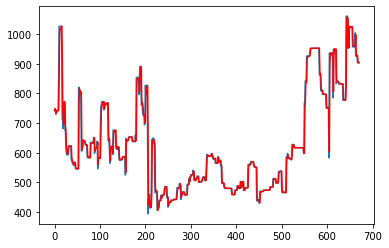

In [ ]:
#FBX04: North America East Coast to China/East Asia
FBX04_model = ARIMA_model(df_FBX04)

predicted=2159.732674, expected=2157.000000
predicted=2160.556115, expected=2157.000000
predicted=2171.030723, expected=2157.000000
predicted=2157.830482, expected=2157.000000
predicted=2157.829642, expected=2157.000000
predicted=2157.828900, expected=2028.000000
predicted=2034.218976, expected=2028.000000
predicted=2030.198838, expected=2028.000000
predicted=2029.721823, expected=2028.000000
predicted=2030.174561, expected=2028.000000
predicted=2035.955742, expected=1968.000000
predicted=1971.178823, expected=1968.000000
predicted=1969.313048, expected=1968.000000
predicted=1969.091271, expected=1968.000000
predicted=1969.299014, expected=1968.000000
predicted=1971.916595, expected=1968.000000
predicted=1968.609320, expected=1968.000000
predicted=1968.608916, expected=1968.000000
predicted=1968.607848, expected=1968.000000
predicted=1968.607446, expected=1968.000000
predicted=1968.607586, expected=1968.000000
predicted=1968.606675, expected=1968.000000
predicted=1968.605874, expected=

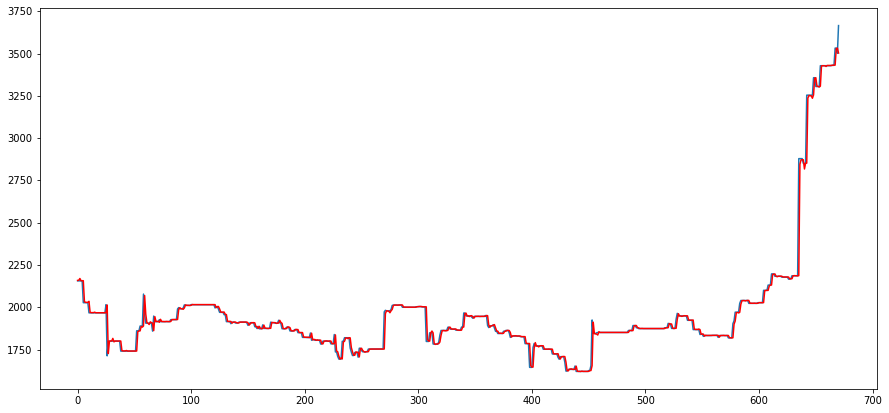

In [ ]:
#FBX22: Europe to North America East Coast
FBX22_model = ARIMA_model(df_FBX22)

predicted=1509.296965, expected=1510.000000
predicted=1509.297607, expected=1510.000000
predicted=1509.298386, expected=1510.000000
predicted=1509.299141, expected=1510.000000
predicted=1509.299963, expected=1510.000000
predicted=1509.300509, expected=1510.000000
predicted=1509.300980, expected=1510.000000
predicted=1509.301971, expected=1510.000000
predicted=1509.302655, expected=1510.000000
predicted=1509.303191, expected=1510.000000
predicted=1509.303937, expected=1510.000000
predicted=1509.304296, expected=1510.000000
predicted=1509.305167, expected=1510.000000
predicted=1509.305986, expected=1510.000000
predicted=1509.306670, expected=1510.000000
predicted=1509.307145, expected=1510.000000
predicted=1509.307843, expected=1510.000000
predicted=1509.308146, expected=1482.000000
predicted=1491.604155, expected=1482.000000
predicted=1486.119793, expected=1482.000000
predicted=1483.726249, expected=1482.000000
predicted=1483.067527, expected=1482.000000
predicted=1482.244417, expected=

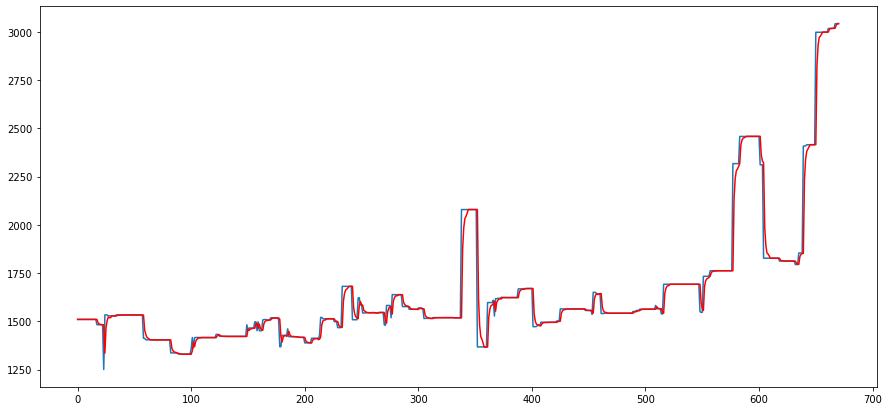

In [ ]:
#FBX26: Europe to South America West Coast
FBX26_model = ARIMA_model(df_FBX26)

In [ ]:
FBX04_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1675
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8897.655
Method:                       css-mle   S.D. of innovations             49.062
Date:                Wed, 12 May 2021   AIC                          17809.310
Time:                        22:21:48   BIC                          17847.275
Sample:                             1   HQIC                         17823.376
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1800      0.976      0.184      0.854      -1.732       2.092
ar.L1.D.y     -0.1378      0.024     -5.640      0.000      -0.186      -0.090
ar.L2.D.y     -0.0178      0.025     -0.722      0.470      -0.066       0.031
ar.L3.D.y     -0.0248      0.025     -1.006      0.314      -0.073       0.023
ar.L4.D.y     -0.0314      0.025     -1.273      0.203      -0.080       0.017
ar.L5.D.y     -0.0172      0.024     -0.703      0.482      -0.065       0.031
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4725           -1.4557j            2.0706           -0.1241
AR.2            1.4725           +1.4557j            2.0706            0.1241
AR.3           -1.1556           -2.0466j            2.3503           -0.3318
AR.4           -1.1556           +2.0466j            2.3503            0.3318
AR.5           -2.4615           -0.0000j            2.4615           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
FBX22_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1675
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9470.217
Method:                       css-mle   S.D. of innovations             69.056
Date:                Wed, 12 May 2021   AIC                          18954.433
Time:                        22:21:48   BIC                          18992.398
Sample:                             1   HQIC                         18968.499
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2430      1.491      0.833      0.405      -1.680       4.166
ar.L1.D.y     -0.0460      0.024     -1.883      0.060      -0.094       0.002
ar.L2.D.y     -0.0123      0.024     -0.505      0.613      -0.060       0.036
ar.L3.D.y     -0.0119      0.024     -0.488      0.625      -0.060       0.036
ar.L4.D.y     -0.0138      0.024     -0.566      0.572      -0.062       0.034
ar.L5.D.y     -0.0476      0.024     -1.950      0.051      -0.095       0.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4152           -1.1344j            1.8137           -0.1075
AR.2            1.4152           +1.1344j            1.8137            0.1075
AR.3           -1.8550           -0.0000j            1.8550           -0.5000
AR.4           -0.6328           -1.7452j            1.8564           -0.3054
AR.5           -0.6328           +1.7452j            1.8564            0.3054
-----------------------------------------------------------------------------
"""

In [ ]:
FBX26_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1675
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9910.635
Method:                       css-mle   S.D. of innovations             89.822
Date:                Wed, 12 May 2021   AIC                          19835.270
Time:                        22:21:48   BIC                          19873.235
Sample:                             1   HQIC                         19849.336
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6711      1.455      0.461      0.645      -2.181       3.523
ar.L1.D.y     -0.2937      0.024    -12.025      0.000      -0.342      -0.246
ar.L2.D.y     -0.1151      0.025     -4.523      0.000      -0.165      -0.065
ar.L3.D.y     -0.0459      0.026     -1.798      0.072      -0.096       0.004
ar.L4.D.y     -0.0351      0.025     -1.380      0.168      -0.085       0.015
ar.L5.D.y     -0.0188      0.024     -0.772      0.440      -0.067       0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3352           -1.6954j            2.1581           -0.1438
AR.2            1.3352           +1.6954j            2.1581            0.1438
AR.3           -1.0704           -1.9029j            2.1833           -0.3315
AR.4           -1.0704           +1.9029j            2.1833            0.3315
AR.5           -2.3925           -0.0000j            2.3925           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
FBX04_model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
chart_studio.tools.set_credentials_file(username='kkrusere',                                              
                                  api_key='WOPCBvXi2SYu4hrw9mdi')

In [ ]:
layout = go.Layout(title='FBX04: North America East Coast to China/East Asia', 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=df_FBX04.index, y=df_FBX04['Price'])],layout=layout)

py.iplot(fig, sharing='public')

In [ ]:

layout = go.Layout(title="FBX22: Europe to North America East Coast", 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=df_FBX22.index, y=df_FBX22['Price'])],layout=layout)

py.iplot(fig, sharing='public')

In [ ]:

layout = go.Layout(title="FBX26: Europe to South America West Coast", 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=df_FBX26.index, y=df_FBX26['Price'])],layout=layout)

py.iplot(fig, sharing='public')

In [ ]:
def create_pred(the_model):
  index = pd.date_range("2021-05-07", periods=100, freq='D')
  
  columns = ["Price"]
  
  df = pd.DataFrame(index=index, columns=columns)

  df['Price'] = the_model.forecast(steps=100)[0]

  return df

 

In [ ]:
FBX04_Pred = create_pred(FBX04_model)
FBX22_Pred = create_pred(FBX22_model)
FBX26_Pred = create_pred(FBX26_model)

In [ ]:
FBX04_Pred

Price
2021-05-07  903.791106
2021-05-08  904.624414
2021-05-09  905.111283
2021-05-10  905.231009
2021-05-11  905.381623
...                ...
2021-08-10  921.721013
2021-08-11  921.901036
2021-08-12  922.081058
2021-08-13  922.261081
2021-08-14  922.441104

[100 rows x 1 columns]

In [ ]:
FBX22_Pred

Price
2021-05-07  3502.614617
2021-05-08  3502.921129
2021-05-09  3499.813040
2021-05-10  3501.767498
2021-05-11  3504.570839
...                 ...
2021-08-10  3617.769135
2021-08-11  3619.012175
2021-08-12  3620.255214
2021-08-13  3621.498254
2021-08-14  3622.741293

[100 rows x 1 columns]

In [ ]:
FBX26_Pred

Price
2021-05-07  3042.794704
2021-05-08  3042.979718
2021-05-09  3043.474509
2021-05-10  3044.310951
2021-05-11  3045.019509
...                 ...
2021-08-10  3106.094900
2021-08-11  3106.766017
2021-08-12  3107.437133
2021-08-13  3108.108249
2021-08-14  3108.779366

[100 rows x 1 columns]

In [ ]:
New_df_FBX04 = df_FBX04.append(FBX04_Pred)
New_df_FBX22 = df_FBX22.append(FBX22_Pred)
New_df_FBX26 = df_FBX26.append(FBX26_Pred)

In [ ]:
layout = go.Layout(title='FBX04 + Pred: North America East Coast to China/East Asia', 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=New_df_FBX04.index, y=New_df_FBX04['Price'])],layout=layout)

py.iplot(fig, sharing='public')

In [ ]:
layout = go.Layout(title="FBX22 + Pred: Europe to North America East Coast", 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=New_df_FBX22.index, y=New_df_FBX22['Price'])],layout=layout)

py.iplot(fig, sharing='public')

In [ ]:
layout = go.Layout(title="FBX26 + Pred: Europe to South America West Coast", 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=New_df_FBX26.index, y=New_df_FBX26['Price'])],layout=layout)

py.iplot(fig, sharing='public')


In [ ]:
new = convert_json_to_dataframe("/content/drive/MyDrive/Data_Mining_Project/raw_response-2.json")
new = date_index_df(new)
new = new.asfreq(freq='D')
new = new.ffill()


In [ ]:
new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1682 entries, 2016-10-03 to 2021-05-11
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1682 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [ ]:
layout = go.Layout(title='FBX04 Updated: North America East Coast to China/East Asia', 
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Price')
                   )
fig = go.Figure([go.Scatter(x=new.index, y=new['Price'])],layout=layout)

py.iplot(fig, sharing='public')